## 데이터 병합

In [2]:
import pandas as pd
data_dir = "../data/"
price = pd.read_csv(data_dir + "processed/item_price_lag_filled.csv")
print(price.head())
trend = pd.read_csv(data_dir + "raw/nst_광어_trend_2025-01-17.csv")
print(trend.head())

trend['age'].unique()

    priceDate item market  minPrice  avgPrice  maxPrice  avgPrice_lag_1  \
0  2015-02-25   광어   가락시장   25000.0   25000.0   25000.0             NaN   
1  2015-02-26   광어   가락시장   25000.0   25000.0   25000.0         25000.0   
2  2015-02-27   광어   가락시장   25000.0   25000.0   25000.0         25000.0   
3  2015-02-28   광어   가락시장   25000.0   25000.0   25000.0         25000.0   
4  2015-03-01   광어   가락시장   25000.0   25000.0   25000.0         25000.0   

   avgPrice_lag_2  avgPrice_lag_3  avgPrice_lag_7  
0             NaN             NaN             NaN  
1             NaN             NaN             NaN  
2         25000.0             NaN             NaN  
3         25000.0         25000.0             NaN  
4         25000.0         25000.0             NaN  
   idx    age name     score        date
0    0  06_12   광어  1.398471  2016-01-01
1    1  06_12   광어  2.725172  2016-01-02
2    2  06_12   광어  1.090436  2016-01-03
3    3  06_12   광어  1.110405  2016-01-04
4    4  06_12   광어  1.492906  20

array(['06_12', '13_18', '19_24', '25_29', '30_34', '35_39', '40_44',
       '45_49', '50_54', '55_59', '60_80'], dtype=object)

In [3]:
def gen_merge_dataset(
    fill, 
    item, 
    drop_cols=[], 
    age=['06_12', '13_18', '19_24', '25_29', '30_34', '35_39', '40_44', '45_49', '50_54', '55_59', '60_80']
):
    price_file = "item_price_lag_filled.csv" if fill == True else "item_price_lag.csv"
    price = pd.read_csv(data_dir + "processed/" + price_file)
    trend = pd.read_csv(data_dir + f"raw/nst_{item}_trend_2025-01-17.csv")
    
    trend = trend[trend["age"].isin(age)]
    
    # 날짜 컬럼 변환
    price["priceDate"] = pd.to_datetime(price["priceDate"])
    trend["date"] = pd.to_datetime(trend["date"])

    # 월 정보 추가
    price["month"] = price["priceDate"].dt.month.astype("category")

    # 요일 정보 추가 (0: 월요일, 6: 일요일)
    price["day_of_week"] = price["priceDate"].dt.dayofweek.astype("category")

    # 하루 전 날짜 계산
    price["merge_date"] = price["priceDate"] - pd.Timedelta(days=1)
    
    # trend 데이터에서 age와 name별로 score 값을 새로운 컬럼으로 변환
    trend_pivot = trend.pivot_table(
        # index="date", columns=["age", "name"], values="score"
        index="date", columns="age", values="score"
    )

    # 멀티 인덱스를 플랫하게 변환
    # trend_pivot.columns = [f"{col[0]}_{col[1]}" for col in trend_pivot.columns]
    trend_pivot.columns = [f"age_{col}" for col in trend_pivot.columns]
    
    # 병합
    ignored_cols = ["minPrice", "maxPrice"] + drop_cols  # 분석에 포함하지 않을 컬럼
    price = price.drop(columns=ignored_cols)
    
    merged_data = pd.merge(price, trend_pivot, left_on="merge_date", right_on="date", how="left")

    # 필요 없는 컬럼 제거
    merged_data.drop(columns=["merge_date", "priceDate"], inplace=True)

    # 결측값 제거
    merged_data = merged_data.dropna()
    
    # 레코드 제거
    merged_data = merged_data[merged_data["item"] == item]

    return merged_data

#### 시각화

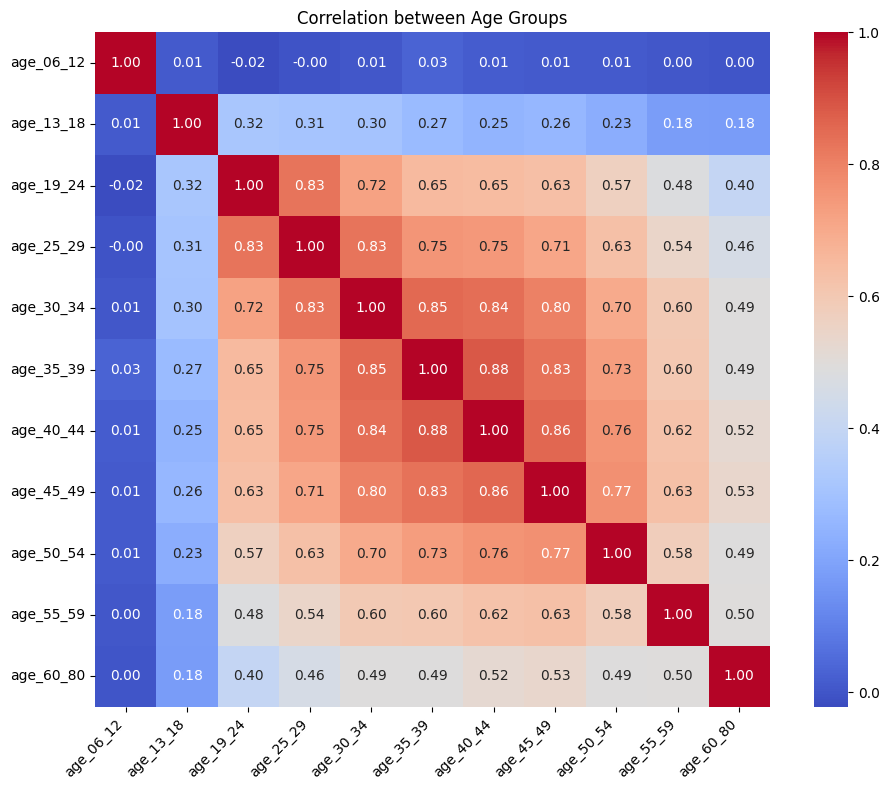

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

merged_data = gen_merge_dataset(fill=True, item="광어")
merged_data

# 데이터프레임에서 연령대 컬럼 선택
age_columns = ['age_06_12', 'age_13_18', 'age_19_24', 'age_25_29', 
               'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 
               'age_50_54', 'age_55_59', 'age_60_80']

# 연령대 간의 상관계수 계산
age_corr = merged_data[age_columns].corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(age_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation between Age Groups")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## AUTO ML

In [5]:
import pandas as pd
from pycaret.regression import setup, compare_models, get_config, pull
import matplotlib.pyplot as plt
import koreanize_matplotlib

def run_automl_feature_importance(data, time_series_split=False):
    # PyCaret 설정
    if time_series_split is True:
        fold_strategy = "timeseries"
        data_split_shuffle = False
        fold_shuffle = False
    else:
        fold_strategy = "kfold"
        data_split_shuffle = True
        fold_shuffle = True
    setup(
        data=data,
        target="avgPrice",
        session_id=1030,  # 재현성을 위한 난수 시드
        normalize=True,  # 데이터 스케일링
        fold_strategy=fold_strategy,
        data_split_shuffle=data_split_shuffle,
        fold_shuffle=fold_shuffle,
        verbose=False
    )

    # 여러 모델 비교 및 최적 모델 선정
    best_model = compare_models(
        include=["rf", "lightgbm", "xgboost", "catboost"],
        verbose=False)
    
    # 최적 모델 이름과 평가지표 출력
    print("Best Model:", type(best_model).__name__)
    print("Model Performance Metrics:")
    metrics = pull()  # PyCaret에서 비교된 모델들의 평가지표를 가져옴
    print(metrics.loc[metrics.index[0]])  # 최적 모델의 성능만 출력
    
    importances = best_model.feature_importances_
    processed_features = get_config("X_train_transformed").columns
    feature_importance_df = pd.DataFrame({
        "Feature": processed_features,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    plt.figure(figsize=(10, 6))
    feature_importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False, color="skyblue")
    plt.title("Feature Importance")
    plt.ylabel("Importance")
    plt.xlabel("Features")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return best_model


Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                350.6461
MSE                             550710.6188
RMSE                               738.5956
R2                                   0.9782
RMSLE                                0.0197
MAPE                                 0.0096
TT (Sec)                              0.202
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

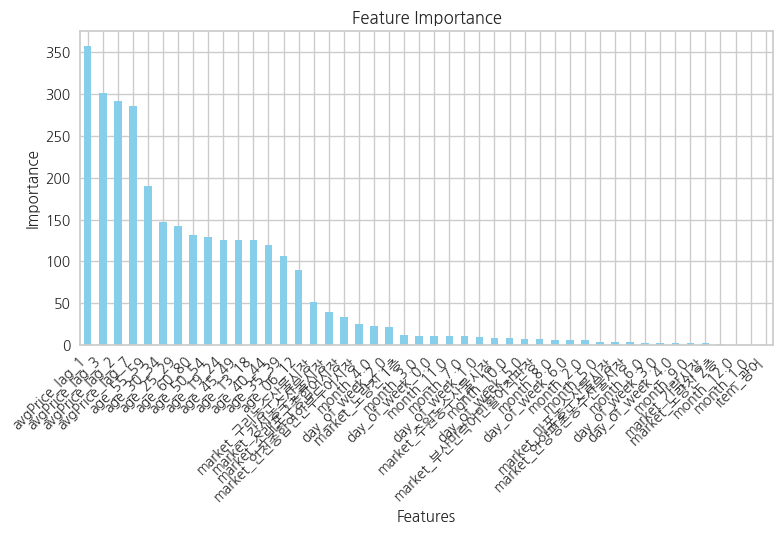

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 1030,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [8]:
# 가격 정보 포함해서 진행

df_merged = gen_merge_dataset(fill=False, item="광어")
best_model = run_automl_feature_importance(df_merged)
best_model.get_params()

Best Model: XGBRegressor
Model Performance Metrics:
Model       Extreme Gradient Boosting
MAE                         1399.0458
MSE                      3772163.1166
RMSE                        1941.9632
R2                             0.8405
RMSLE                          0.0546
MAPE                           0.0398
TT (Sec)                        0.241
Name: xgboost, dtype: object


<Figure size 1000x600 with 0 Axes>

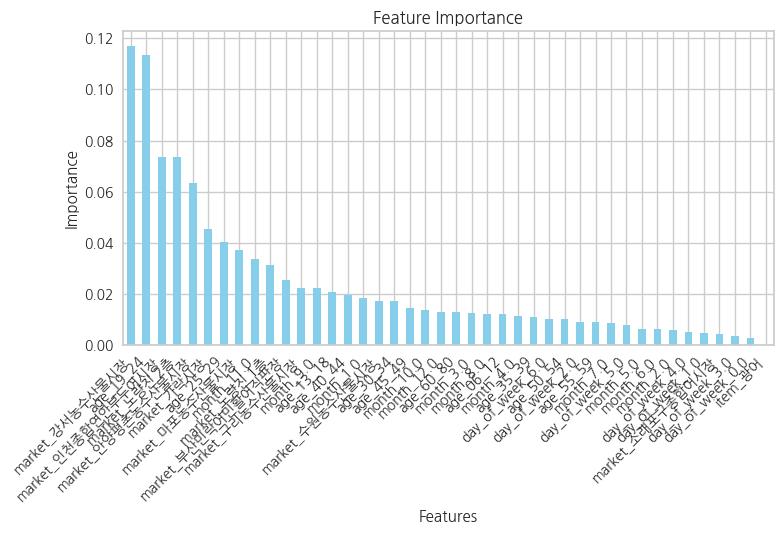

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 1030,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'auto',
 'validate_parameters': None,
 'verbosity': 0}

In [22]:
# 가격 정보 제외하고 진행

df_merged = gen_merge_dataset(fill=False, item="광어", drop_cols=[
    "avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7"
])

best_model = run_automl_feature_importance(df_merged)
best_model.get_params()

### 최적 모델 및 피쳐 중요도 확인

농어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3414.7266
MSE                           17391187.5089
RMSE                              4169.6121
R2                                   0.3614
RMSLE                                 0.119
MAPE                                 0.0986
TT (Sec)                              0.367
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

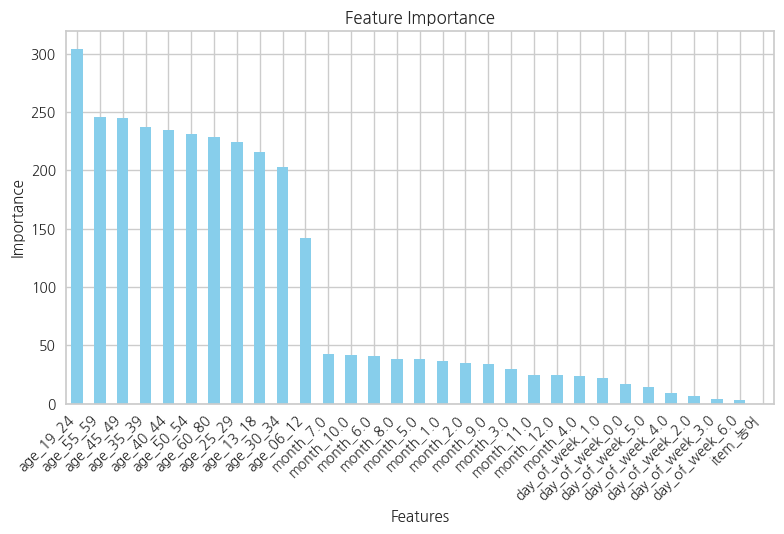

농어 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3476.6314
MSE                           17908833.2532
RMSE                                4231.64
R2                                    0.344
RMSLE                                0.1205
MAPE                                    0.1
TT (Sec)                              0.245
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

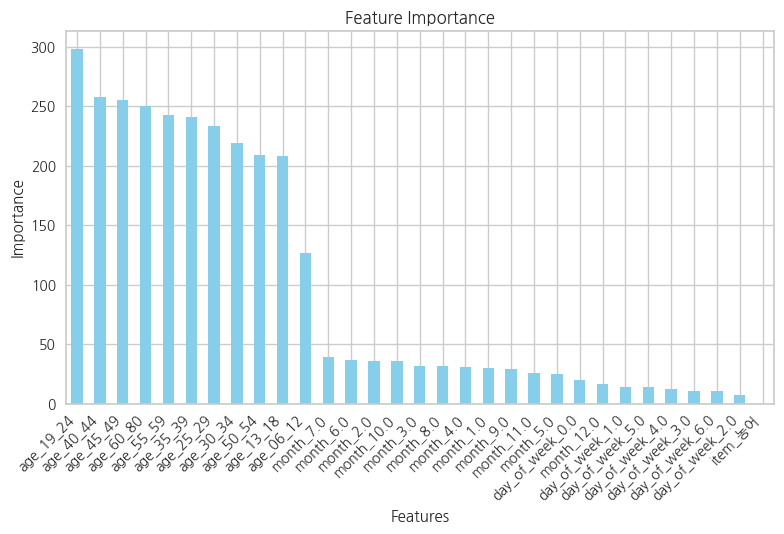

광어 filled True
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  2743.7092
MSE              12042560.5739
RMSE                 3469.4002
R2                      0.4879
RMSLE                   0.0944
MAPE                    0.0764
TT (Sec)                 1.145
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

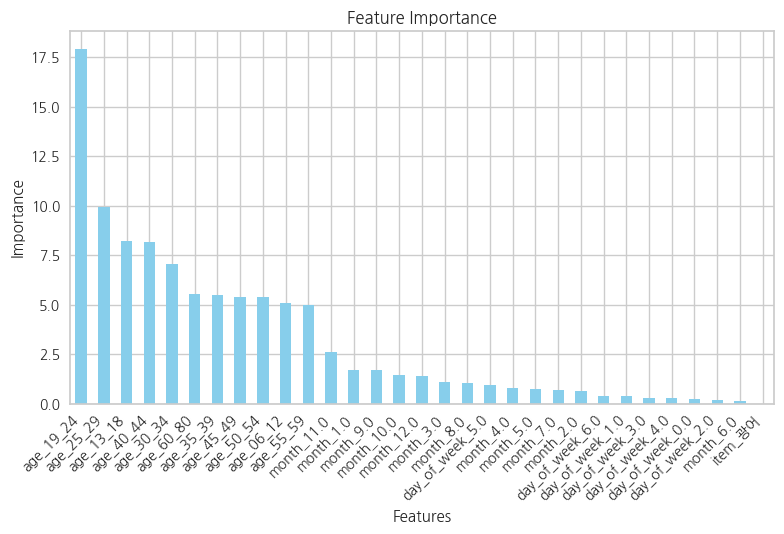

광어 filled False
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  2734.5234
MSE              12127427.9917
RMSE                 3482.2475
R2                      0.4874
RMSLE                   0.0939
MAPE                    0.0755
TT (Sec)                 0.992
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

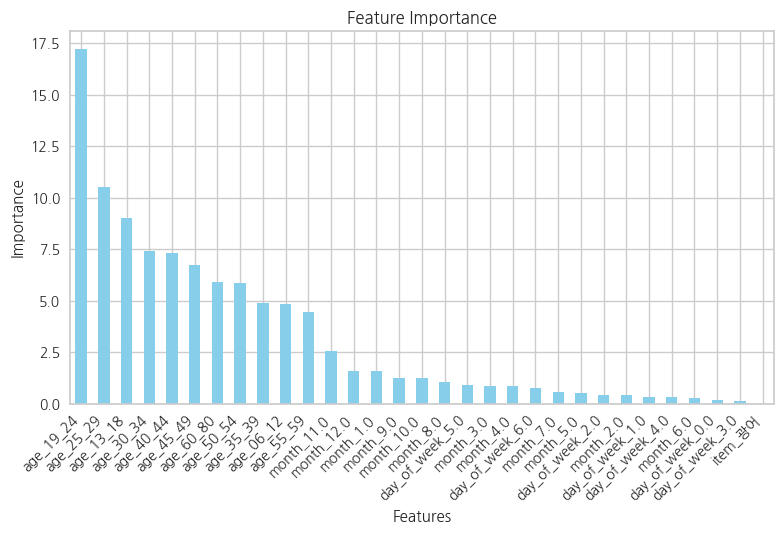

대게 filled True
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  6099.2084
MSE              60132429.7987
RMSE                   7753.32
R2                      0.6567
RMSLE                    0.145
MAPE                    0.1163
TT (Sec)                 1.033
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

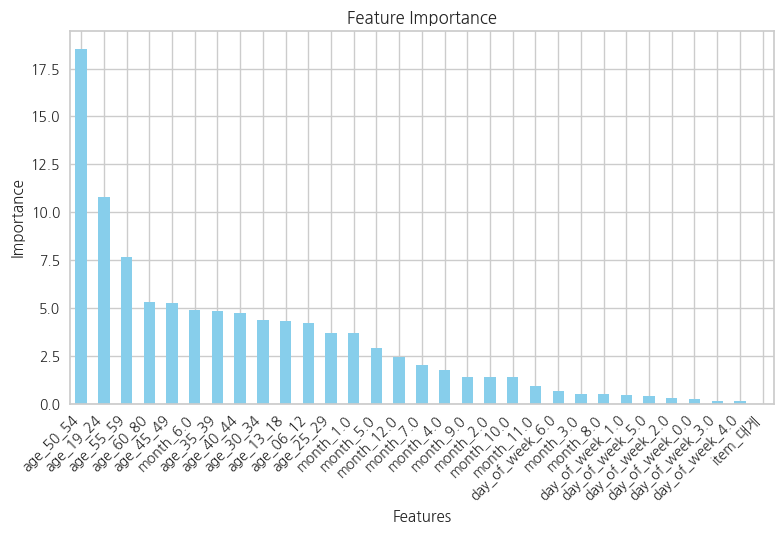

대게 filled False
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  6000.9605
MSE              58616344.7479
RMSE                 7655.5656
R2                      0.6653
RMSLE                   0.1407
MAPE                    0.1124
TT (Sec)                 1.006
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

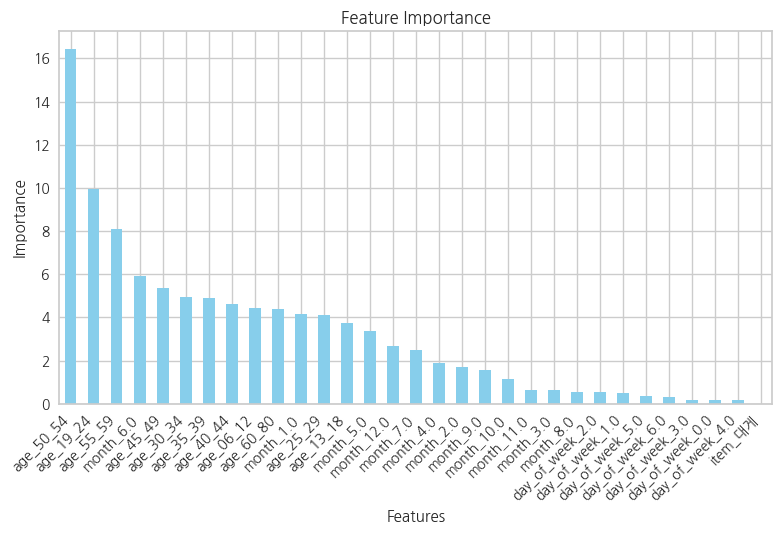

연어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                545.5237
MSE                             475003.8479
RMSE                               689.1494
R2                                   0.7117
RMSLE                                 0.137
MAPE                                 0.1162
TT (Sec)                              0.235
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

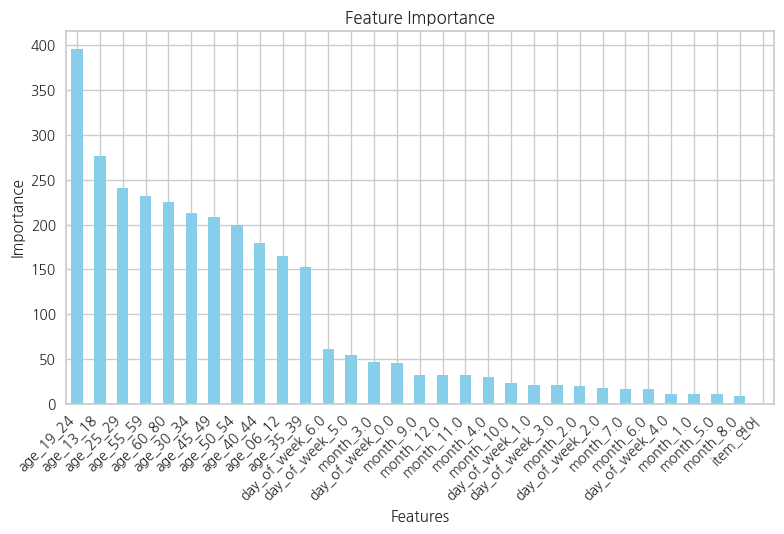

연어 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                 540.418
MSE                             469302.8988
RMSE                               684.9406
R2                                   0.7236
RMSLE                                0.1344
MAPE                                 0.1137
TT (Sec)                              0.249
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

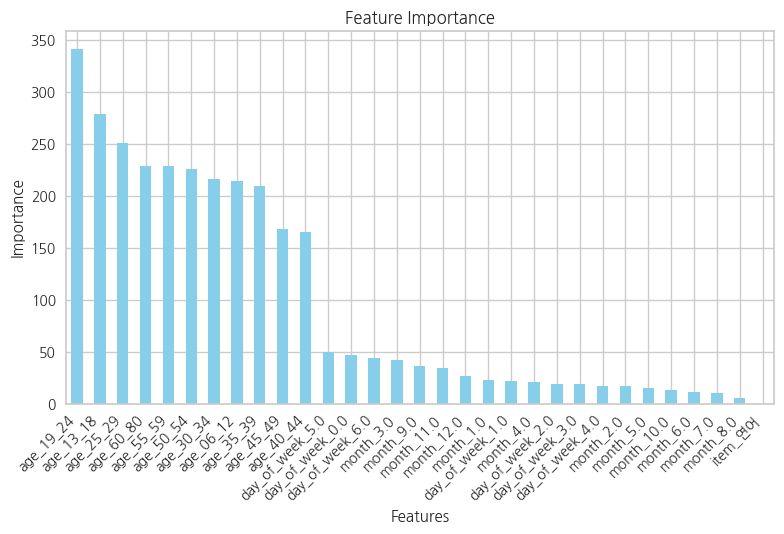

우럭 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                3482.164
MSE                           18520021.9748
RMSE                              4301.1765
R2                                  -0.2199
RMSLE                                0.1285
MAPE                                 0.1054
TT (Sec)                               0.24
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

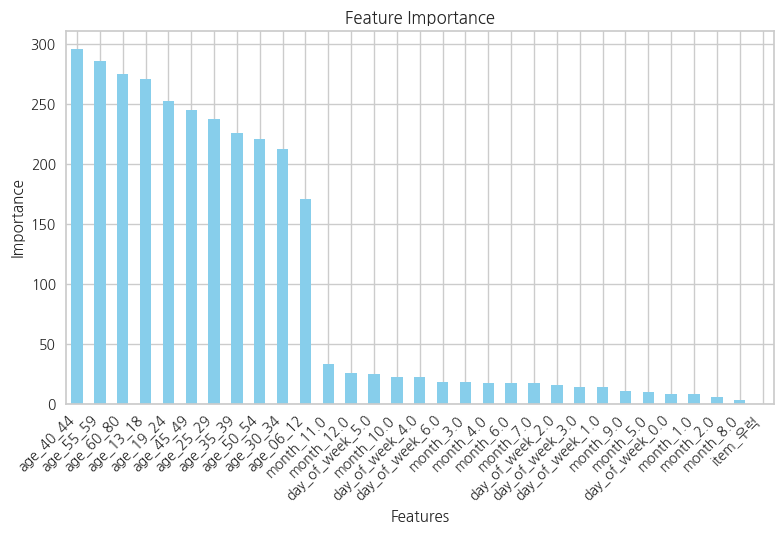

우럭 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                3568.916
MSE                            19344397.499
RMSE                              4396.3534
R2                                  -0.2402
RMSLE                                0.1314
MAPE                                 0.1082
TT (Sec)                              0.235
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

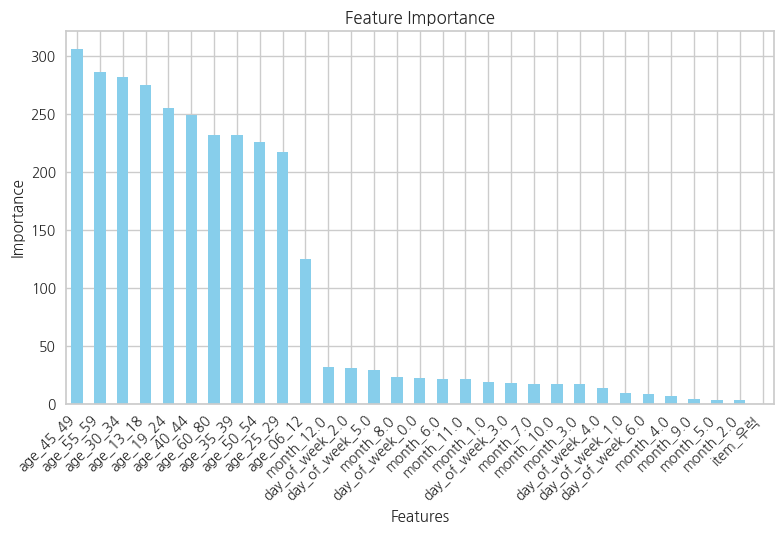

참돔 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               2751.9681
MSE                           11923018.5888
RMSE                                 3452.7
R2                                   0.1243
RMSLE                                0.0937
MAPE                                 0.0756
TT (Sec)                              0.259
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

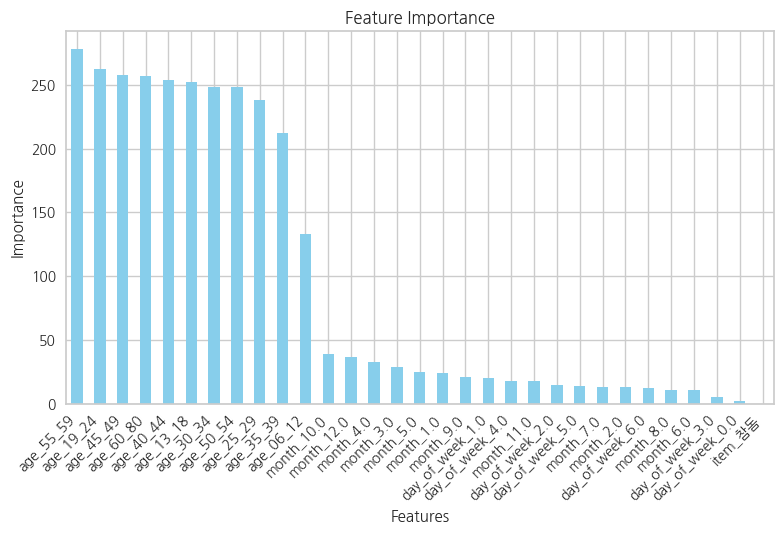

참돔 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               2855.8564
MSE                           12455880.3626
RMSE                              3528.9104
R2                                   0.1625
RMSLE                                0.0954
MAPE                                 0.0783
TT (Sec)                              0.214
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

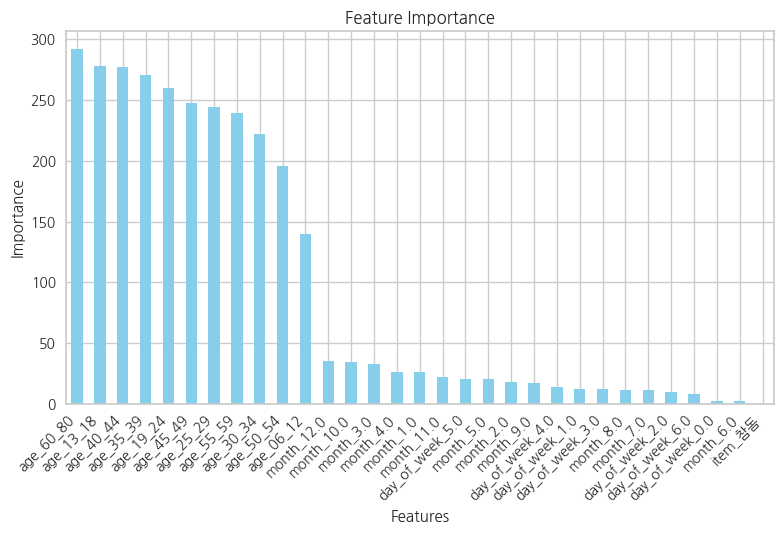

방어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                                5897.622
MSE                           49093673.3941
RMSE                              7006.1135
R2                                   0.1117
RMSLE                                0.2058
MAPE                                 0.1782
TT (Sec)                              0.221
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

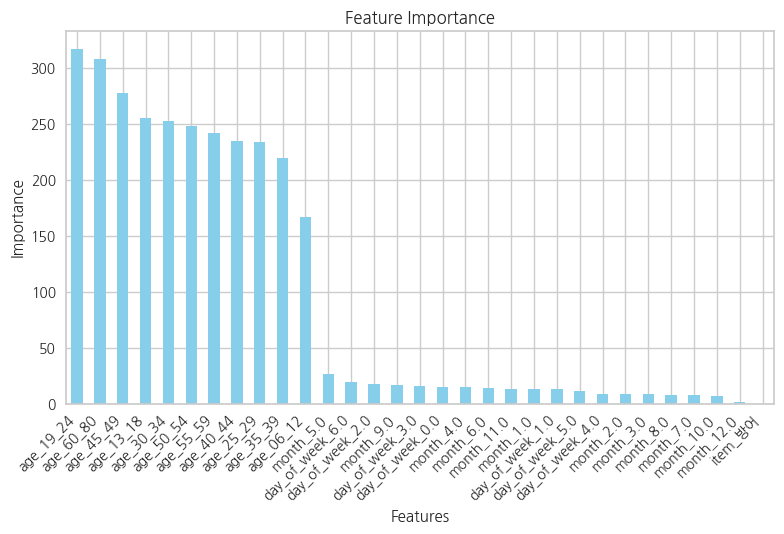

방어 filled False
Best Model: RandomForestRegressor
Model Performance Metrics:
Model       Random Forest Regressor
MAE                       5037.4382
MSE                   40555683.8575
RMSE                      6352.4397
R2                            0.219
RMSLE                        0.1725
MAPE                         0.1369
TT (Sec)                      0.087
Name: rf, dtype: object


<Figure size 1000x600 with 0 Axes>

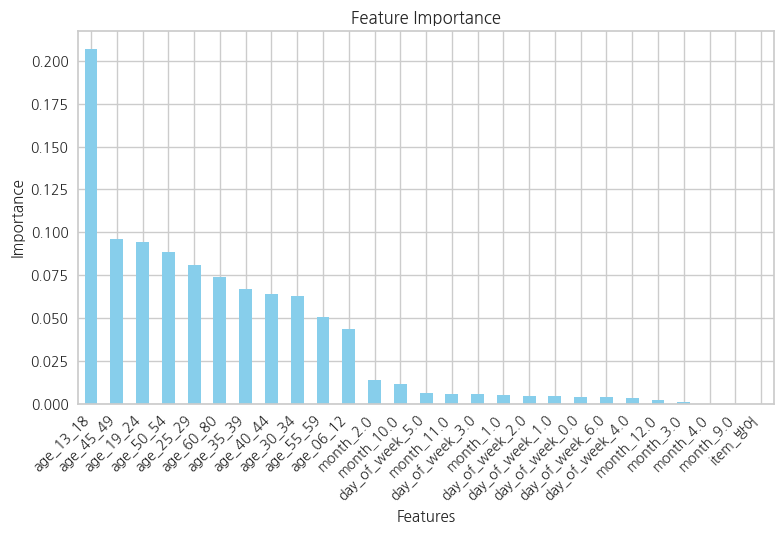

In [23]:
item_list = ['농어', '광어', '대게', '연어', '우럭', '참돔', '방어']
for item in item_list:
    for fill in [True, False]:
        print(item, 'filled', fill)
        df_merged = gen_merge_dataset(fill=fill, item=item, drop_cols=[
            "avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7", "market"
        ])
        run_automl_feature_importance(df_merged)

#### 시계열 데이터 분할 및 성능 평가

농어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               4474.2532
MSE                           29617702.1977
RMSE                              5054.2366
R2                                  -1.1706
RMSLE                                0.1424
MAPE                                 0.1248
TT (Sec)                              0.244
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

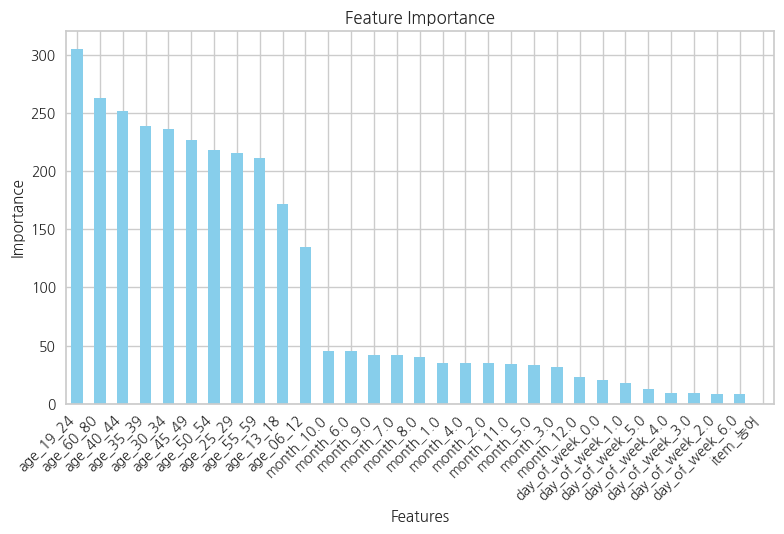

농어 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               4545.9639
MSE                           30254501.0299
RMSE                               5071.675
R2                                  -1.2538
RMSLE                                0.1432
MAPE                                 0.1273
TT (Sec)                              0.247
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

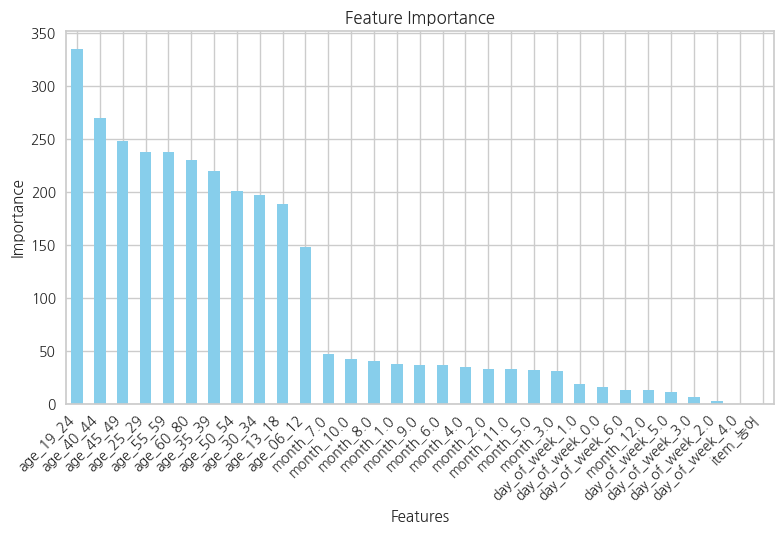

광어 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3827.3472
MSE                           20894721.0133
RMSE                              4351.4976
R2                                  -0.7701
RMSLE                                0.1179
MAPE                                 0.1072
TT (Sec)                              0.239
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

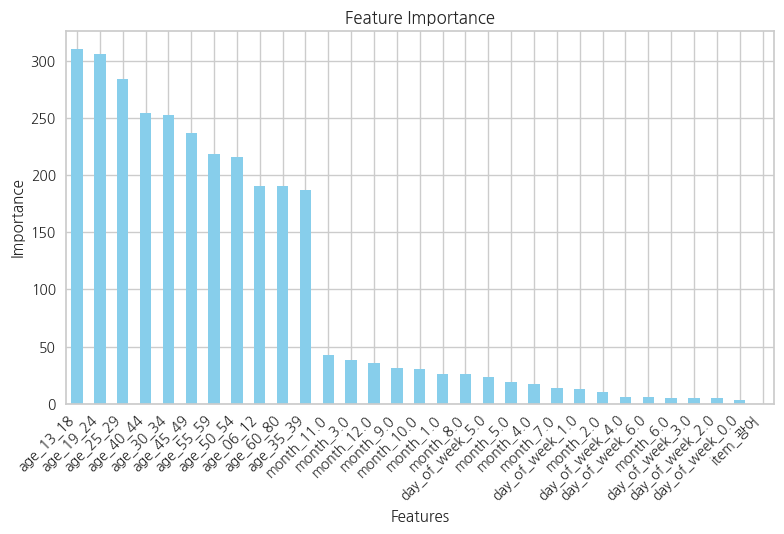

광어 filled False
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  3861.3922
MSE              21857648.9203
RMSE                 4386.3531
R2                     -1.1338
RMSLE                   0.1176
MAPE                    0.1065
TT (Sec)                 0.863
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

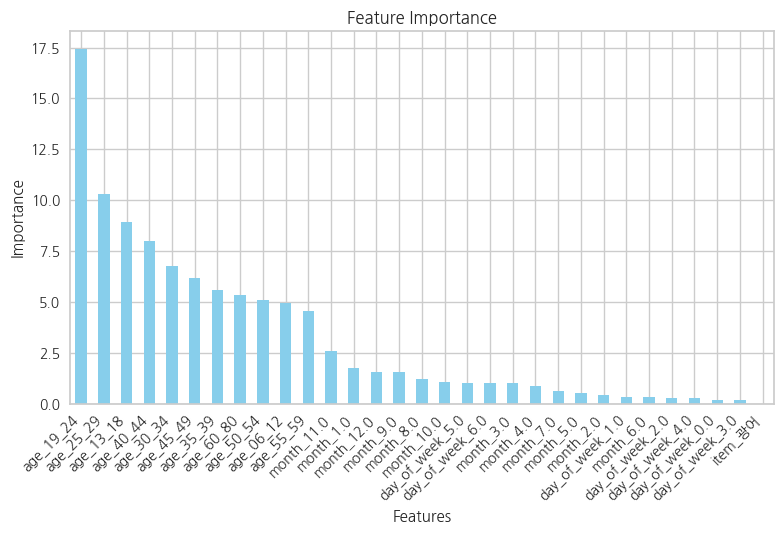

대게 filled True
Best Model: XGBRegressor
Model Performance Metrics:
Model       Extreme Gradient Boosting
MAE                         7354.7181
MSE                        86061507.1
RMSE                        8690.0045
R2                             0.2628
RMSLE                          0.1615
MAPE                           0.1377
TT (Sec)                        0.055
Name: xgboost, dtype: object


<Figure size 1000x600 with 0 Axes>

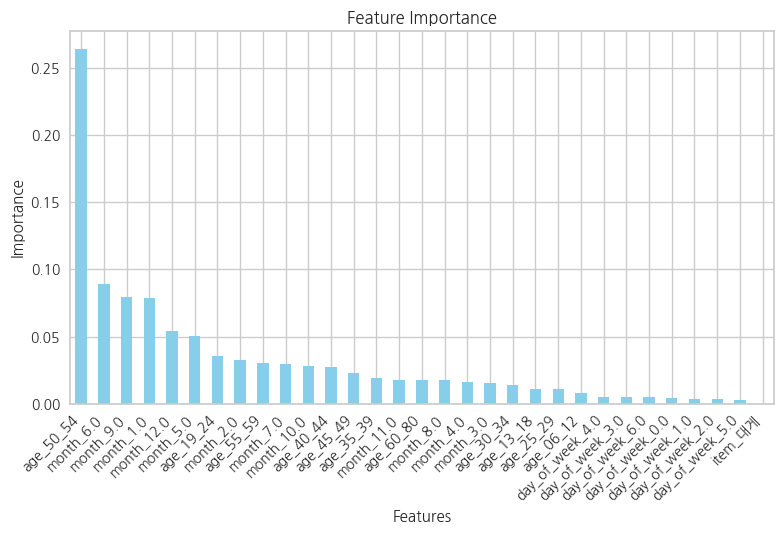

대게 filled False
Best Model: RandomForestRegressor
Model Performance Metrics:
Model       Random Forest Regressor
MAE                       7112.2972
MSE                   81698890.6952
RMSE                      8482.5067
R2                           0.2847
RMSLE                        0.1571
MAPE                         0.1334
TT (Sec)                      0.579
Name: rf, dtype: object


<Figure size 1000x600 with 0 Axes>

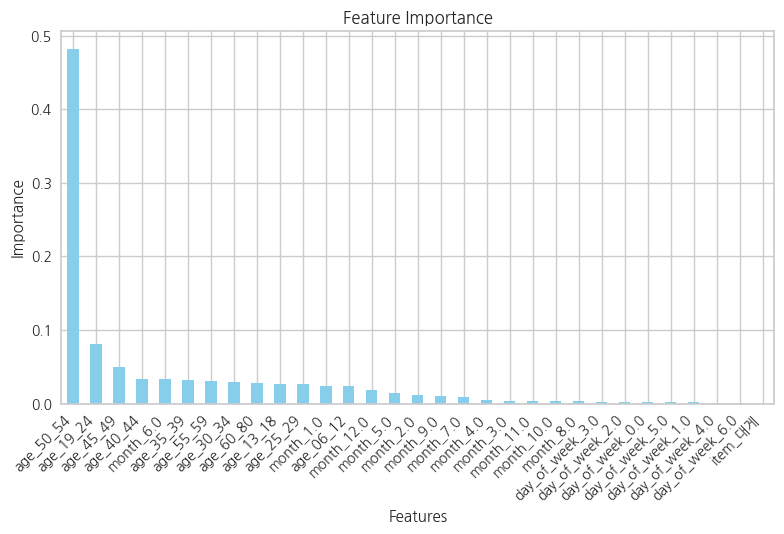

연어 filled True
Best Model: XGBRegressor
Model Performance Metrics:
Model       Extreme Gradient Boosting
MAE                          642.5596
MSE                       742996.9562
RMSE                         754.9506
R2                            -1.2334
RMSLE                          0.1585
MAPE                           0.1355
TT (Sec)                        0.065
Name: xgboost, dtype: object


<Figure size 1000x600 with 0 Axes>

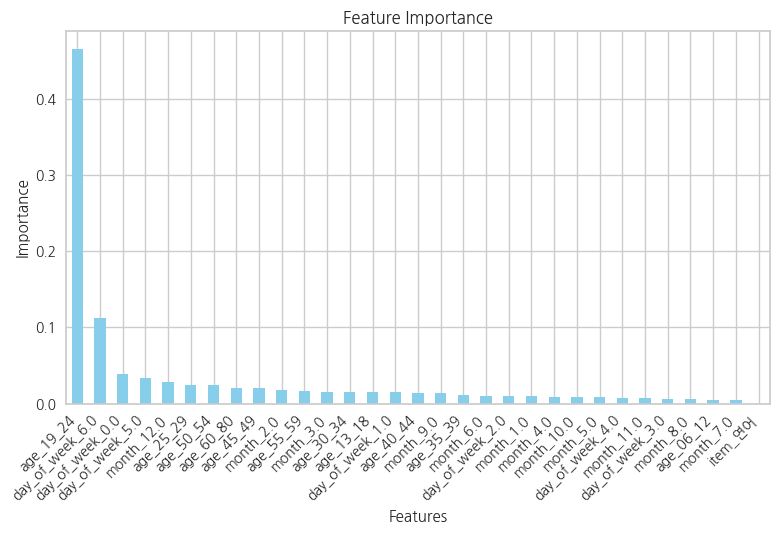

연어 filled False
Best Model: XGBRegressor
Model Performance Metrics:
Model       Extreme Gradient Boosting
MAE                          642.2884
MSE                       762847.3648
RMSE                         739.6659
R2                            -1.0662
RMSLE                           0.154
MAPE                           0.1339
TT (Sec)                        0.076
Name: xgboost, dtype: object


<Figure size 1000x600 with 0 Axes>

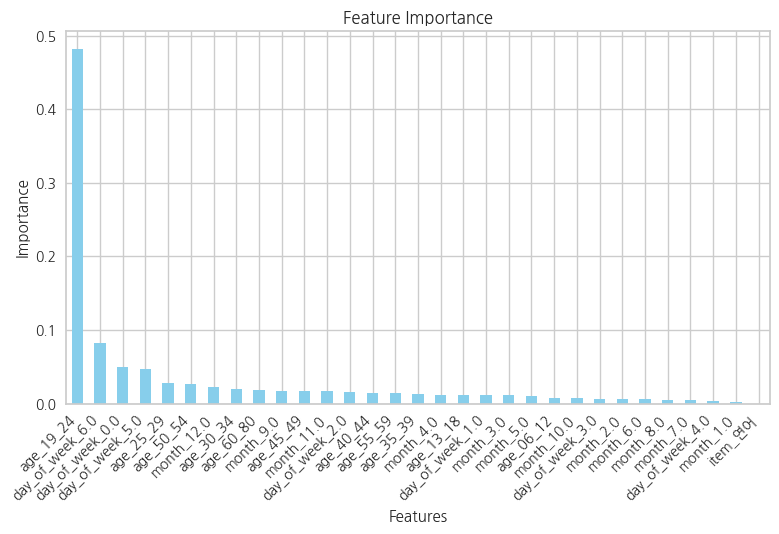

우럭 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               4242.6092
MSE                           23748356.0989
RMSE                              4588.9624
R2                                 -11.2361
RMSLE                                0.1346
MAPE                                 0.1343
TT (Sec)                              0.224
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

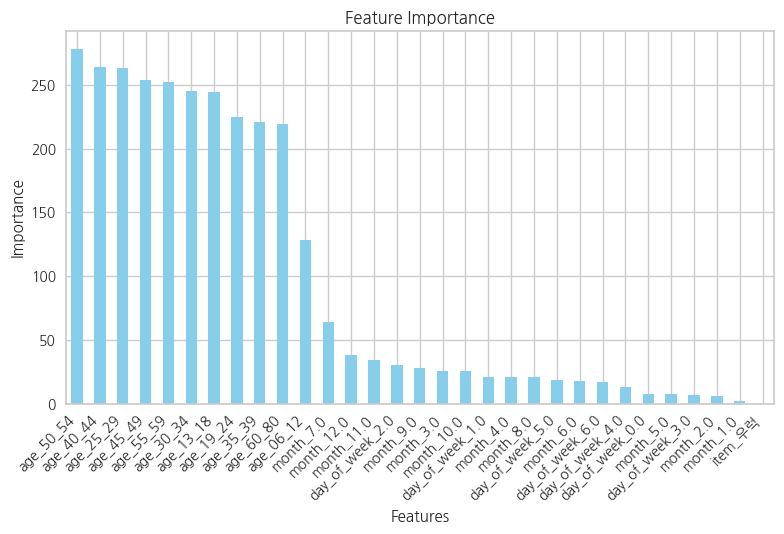

우럭 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               4227.3539
MSE                            23587947.533
RMSE                              4620.3635
R2                                 -10.9859
RMSLE                                0.1354
MAPE                                 0.1335
TT (Sec)                              0.215
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

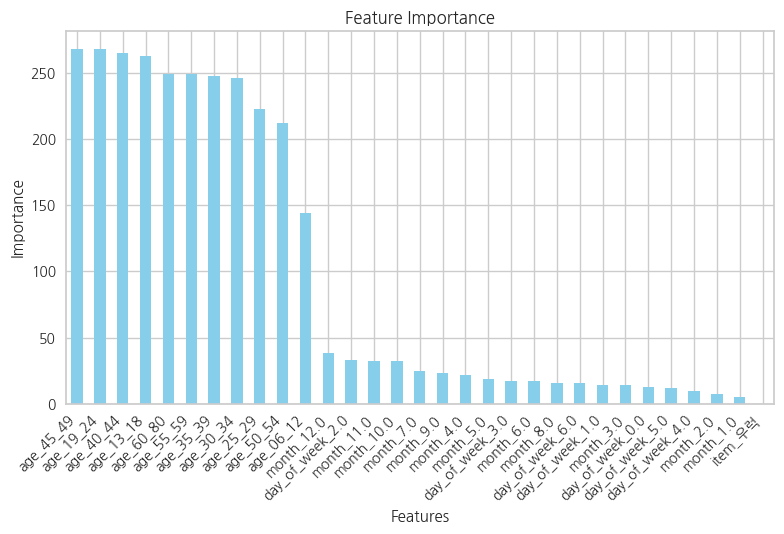

참돔 filled True
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3443.8989
MSE                           17425365.4921
RMSE                              3911.5214
R2                                  -3.6929
RMSLE                                0.1049
MAPE                                 0.0941
TT (Sec)                              0.237
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

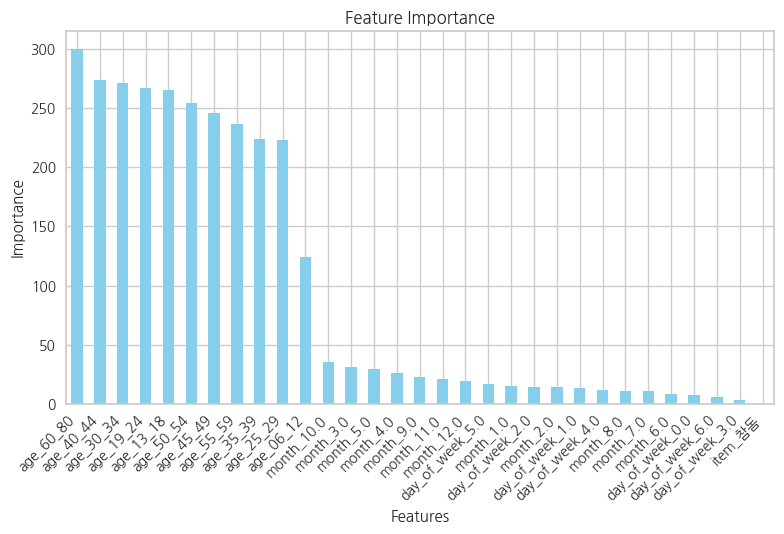

참돔 filled False
Best Model: LGBMRegressor
Model Performance Metrics:
Model       Light Gradient Boosting Machine
MAE                               3641.3188
MSE                           18671360.4474
RMSE                              4108.8389
R2                                  -4.4018
RMSLE                                0.1099
MAPE                                 0.1003
TT (Sec)                              0.213
Name: lightgbm, dtype: object


<Figure size 1000x600 with 0 Axes>

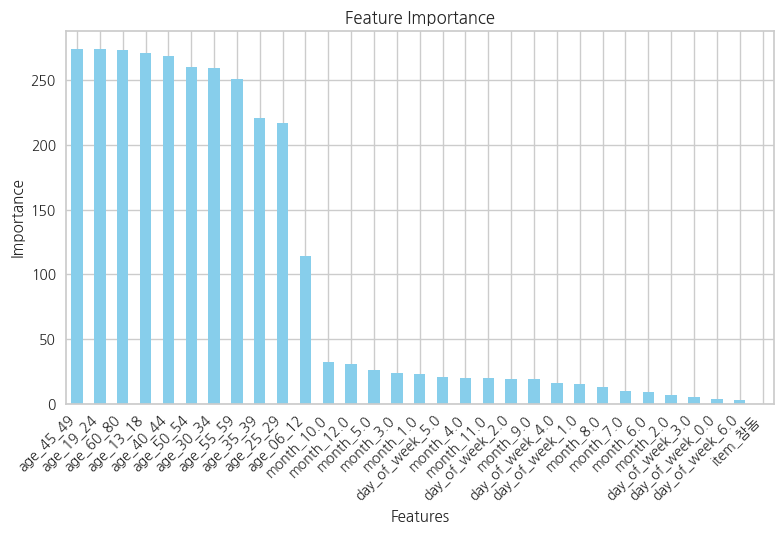

방어 filled True
Best Model: CatBoostRegressor
Model Performance Metrics:
Model       CatBoost Regressor
MAE                  6090.2467
MSE              56554547.0267
RMSE                 7149.9925
R2                     -1.7464
RMSLE                   0.2046
MAPE                    0.1926
TT (Sec)                 0.617
Name: catboost, dtype: object


<Figure size 1000x600 with 0 Axes>

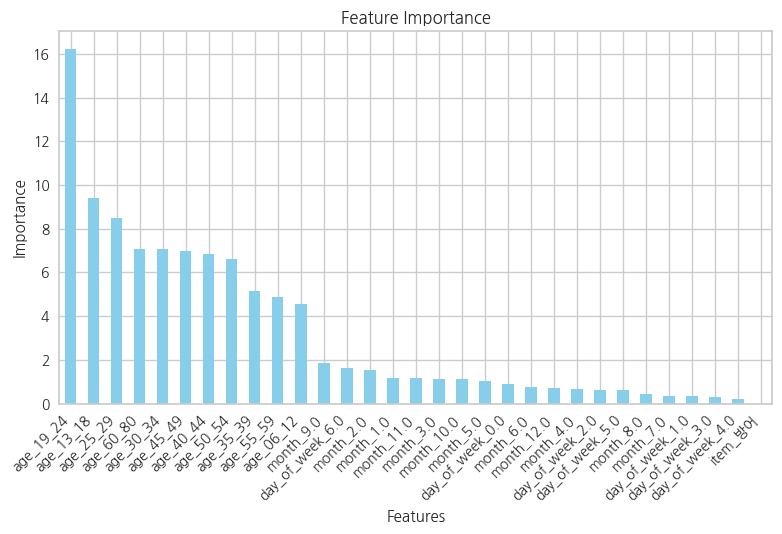

방어 filled False
Best Model: RandomForestRegressor
Model Performance Metrics:
Model       Random Forest Regressor
MAE                       5897.8408
MSE                   51000001.4969
RMSE                      6954.9736
R2                          -3.8865
RMSLE                         0.182
MAPE                         0.1589
TT (Sec)                      0.065
Name: rf, dtype: object


<Figure size 1000x600 with 0 Axes>

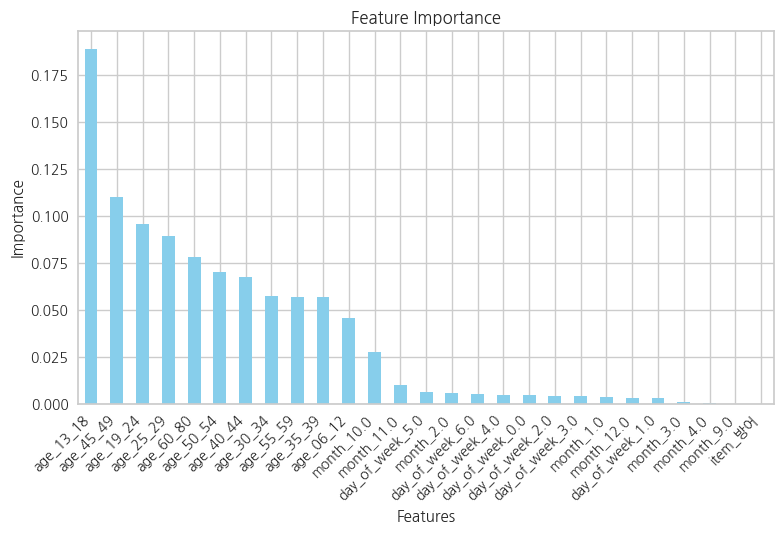

In [24]:
item_list = ['농어', '광어', '대게', '연어', '우럭', '참돔', '방어']
for item in item_list:
    for fill in [True, False]:
        print(item, 'filled', fill)
        df_merged = gen_merge_dataset(fill=fill, item=item, drop_cols=[
            "avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7", "market"
        ])
        run_automl_feature_importance(df_merged, time_series_split=True)

#### 모델 튜닝
- 데이터: filled
- 모델: LGBM

In [44]:
from pycaret.regression import setup, create_model, tune_model


df_merged = gen_merge_dataset(fill=False, item="광어", drop_cols=[
    "avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7"
])

# PyCaret 설정
setup(data=df_merged, target="avgPrice", session_id=1030)

# LightGBM 모델 생성
lgbm_model = create_model("lightgbm")
lgbm_model.get_params()

,Description,Value
0,Session id,1030
1,Target,avgPrice
2,Target type,Regression
3,Original data shape,"(26526, 16)"
4,Transformed data shape,"(26526, 43)"
5,Transformed train set shape,"(18568, 43)"
6,Transformed test set shape,"(7958, 43)"
7,Numeric features,11
8,Categorical features,4
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1641.0879,5106447.0705,2259.7449,0.7769,0.0636,0.0467
1,1609.5933,4919652.0832,2218.0289,0.7953,0.0627,0.0460
2,1630.1132,5044038.3117,2245.8937,0.7895,0.0631,0.0464
3,1701.2273,5314505.0768,2305.3210,0.7672,0.0652,0.0487
4,1706.9817,5616603.5963,2369.9375,0.7656,0.0667,0.0488
5,1645.1101,5049532.3053,2247.1164,0.7926,0.0633,0.0468
6,1620.9612,4969978.2029,2229.3448,0.7870,0.0632,0.0465
7,1672.9111,5031087.3864,2243.0086,0.7906,0.0641,0.0481
8,1648.6533,5070358.8631,2251.7457,0.7819,0.0646,0.0479


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 1030,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [26]:

# LightGBM 모델 튜닝
tuned_lgbm_model = tune_model(
    lgbm_model,
    custom_grid={
        "num_leaves": [31, 50, 70],        # 트리의 최대 잎 노드 수
        "learning_rate": [0.01, 0.05, 0.1],  # 학습률
        "max_depth": [-1, 10, 20],
        "n_estimators": [1000, 2000, 3000, 5000]    # 트리 개수
    }
)

print("Best Parameters:")
print(tuned_lgbm_model.get_params())
# {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 50, 'objective': None, 'random_state': 1030, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
# {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 2000, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 1030, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1262.8698,3105492.0511,1762.2406,0.8643,0.0493,0.0356
1,1217.2430,2840736.1197,1685.4483,0.8818,0.0472,0.0344
2,1263.5630,3123794.4609,1767.4259,0.8697,0.0493,0.0357
3,1290.1540,3085906.8132,1756.6749,0.8648,0.0495,0.0367
4,1310.2040,3393866.8264,1842.2451,0.8584,0.0517,0.0372
5,1278.1756,3072306.3347,1752.7996,0.8738,0.0488,0.0359
6,1256.8516,3046023.2225,1745.2860,0.8694,0.0493,0.0358
7,1267.2526,2956261.2638,1719.3782,0.8770,0.0485,0.0359
8,1278.0063,3172880.5083,1781.2581,0.8635,0.0506,0.0367


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 2000, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 1030, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


#### 모델 성능 시각화

In [27]:
from pycaret.regression import predict_model

# 튜닝된 모델로 예측
predictions = predict_model(tuned_lgbm_model)
# 예측 결과 확인
print(predictions.head())
print(predictions.columns)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1259.4363,3074508.2603,1753.4276,0.8699,0.0495,0.0359


      item      market month day_of_week  age_06_12  age_13_18  age_19_24  \
23676   광어  안양평촌농수산물시장     3           5   1.165083   1.888559   1.844615   
4299    광어    강서농수산물시장     6           3   1.981171   1.771613   1.851331   
10787   광어      노량진 1층    12           1   1.197724   1.556293   1.392066   
21413   광어   소래포구종합어시장     3           5   1.000000   1.407582   1.324456   
22455   광어    수원농수산물시장     8           3   3.836696   1.888632   1.531290   

       age_25_29  age_30_34  age_35_39  age_40_44  age_45_49  age_50_54  \
23676   1.793443   2.091304   1.750475   1.945820   2.017063   2.436998   
4299    1.772140   1.611417   1.554505   1.664427   1.427818   2.145879   
10787   1.531184   1.526878   1.418710   1.391724   1.333101   1.338018   
21413   1.372483   1.408530   1.302537   1.260844   1.293218   1.330773   
22455   1.589959   1.518595   1.414083   1.367261   1.544540   1.540739   

       age_55_59  age_60_80  avgPrice  prediction_label  
23676   2.518978   2.142188 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1259.4363,3074508.2603,1753.4276,0.8699,0.0495,0.0359


R2 Score: 0.8699
RMSE: 1753.43


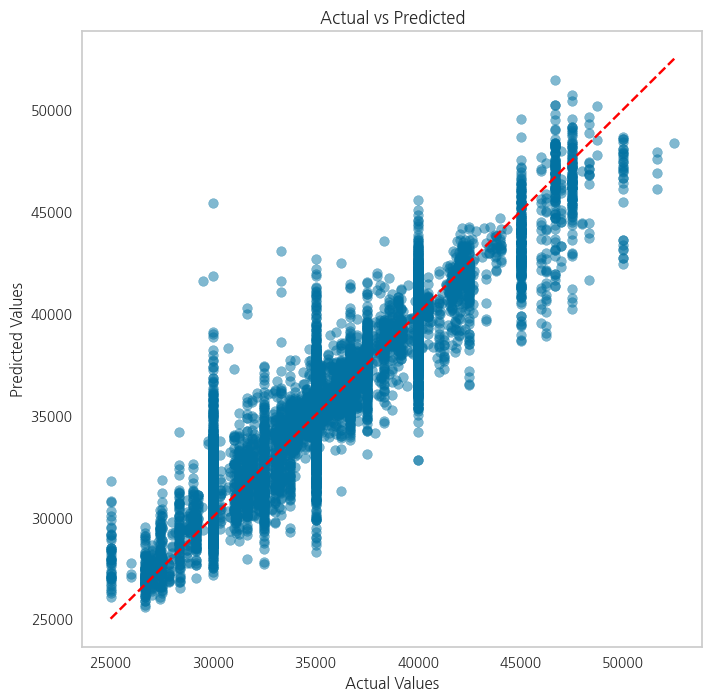

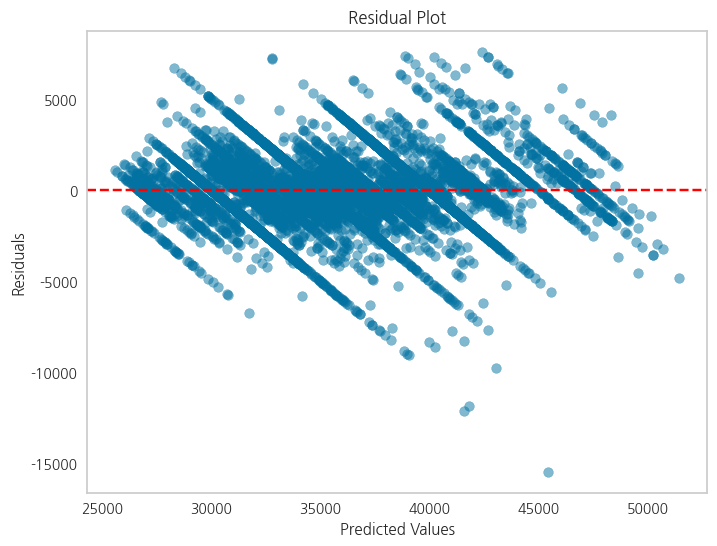

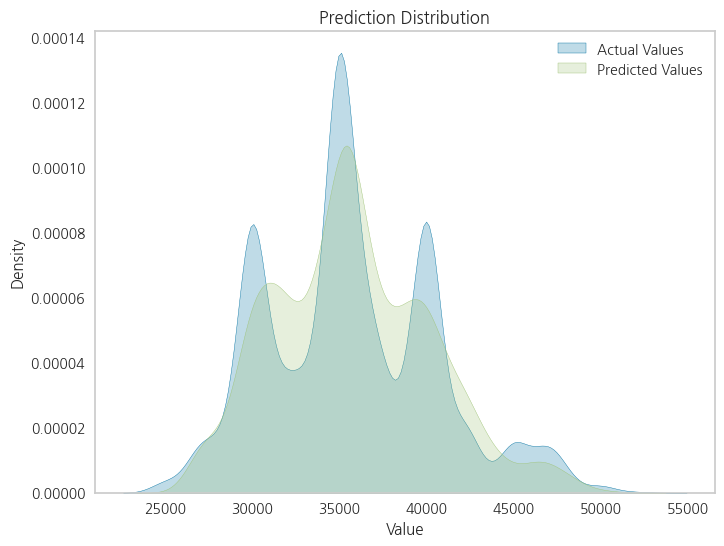

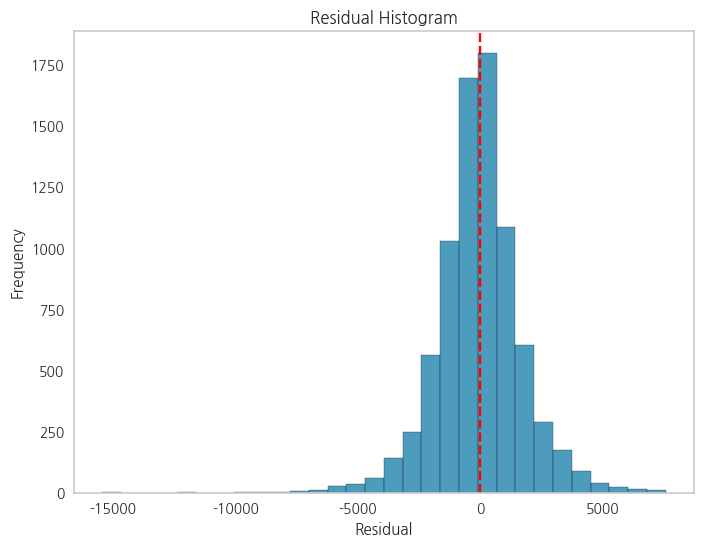

In [28]:
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# PyCaret의 predict_model 함수로 예측 수행
predictions = predict_model(tuned_lgbm_model)

# 실제 값과 예측 값 추출
y_true = predictions["avgPrice"]
y_pred = predictions["prediction_label"]

# R2 및 RMSE 계산
r2 = r2_score(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# 1. 실제 값 vs 예측 값 플롯
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()

# 2. 잔차 플롯
residuals = y_true - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# 3. 예측 값 분포
plt.figure(figsize=(8, 6))
sns.kdeplot(y_true, label="Actual Values", shade=True)
sns.kdeplot(y_pred, label="Predicted Values", shade=True)
plt.title("Prediction Distribution")
plt.xlabel("Value")
plt.legend()
plt.grid()
plt.show()

# 4. 잔차 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.title("Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color="red", linestyle="--")
plt.grid()
plt.show()


### 피처 축소 후 성능 확인

In [29]:
df_merged = gen_merge_dataset(fill=False, item="광어", drop_cols=[
    "avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7"
])
df_merged.info()
df_merged.head()
df_merged.columns

<class 'pandas.core.frame.DataFrame'>
Index: 26526 entries, 136 to 27157
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   avgPrice     26526 non-null  int64   
 1   item         26526 non-null  object  
 2   market       26526 non-null  object  
 3   month        26526 non-null  category
 4   day_of_week  26526 non-null  category
 5   age_06_12    26526 non-null  float64 
 6   age_13_18    26526 non-null  float64 
 7   age_19_24    26526 non-null  float64 
 8   age_25_29    26526 non-null  float64 
 9   age_30_34    26526 non-null  float64 
 10  age_35_39    26526 non-null  float64 
 11  age_40_44    26526 non-null  float64 
 12  age_45_49    26526 non-null  float64 
 13  age_50_54    26526 non-null  float64 
 14  age_55_59    26526 non-null  float64 
 15  age_60_80    26526 non-null  float64 
dtypes: category(2), float64(11), int64(1), object(2)
memory usage: 3.1+ MB


Index(['avgPrice', 'item', 'market', 'month', 'day_of_week', 'age_06_12',
       'age_13_18', 'age_19_24', 'age_25_29', 'age_30_34', 'age_35_39',
       'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_80'],
      dtype='object')

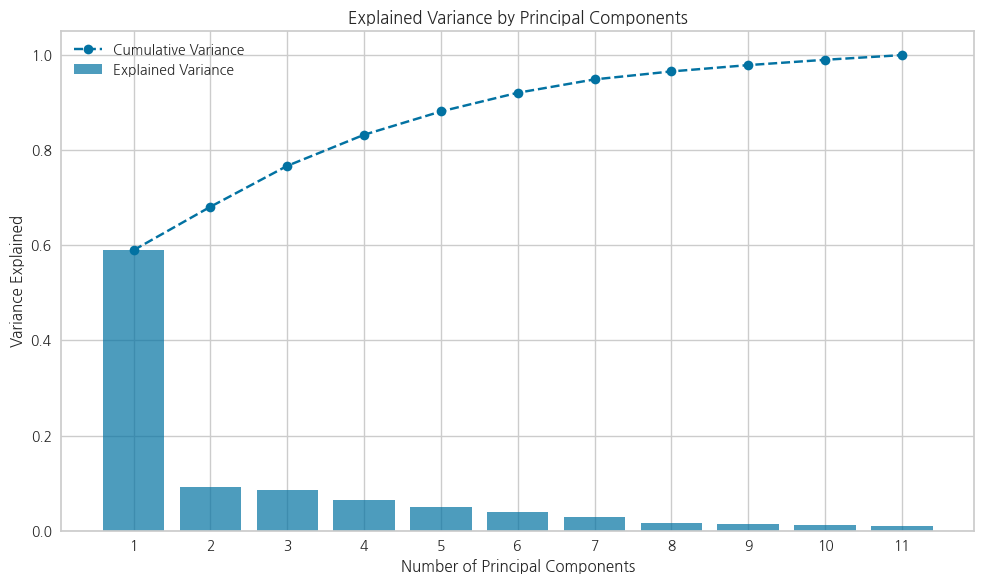

In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 스케일링
features = [
    'age_06_12', 'age_13_18', 'age_19_24', 'age_25_29', 'age_30_34', 'age_35_39',
    'age_40_44', 'age_45_49', 'age_50_54', 'age_55_59', 'age_60_80'
]  # 포함된 피처를 나열
df_features = df_merged[features]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

# 2. PCA 적용 (전체 피처를 대상으로)
pca = PCA()
pca.fit(scaled_features)

# 3. 설명된 분산 비율 계산
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 4. 설명력 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', label='Cumulative Variance')
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [35]:
principal_components = pca.fit_transform(scaled_features)
 # 설명력이 80%에 근접하기 위한 주성분의 개수(3개)
pca_df = pd.DataFrame(principal_components[:,:3], columns=['trend_PC1', 'trend_PC2', 'trend_PC3'])
# # 설명력이 90% 이상 되려면 6개 주성분 필요
# pca_df = pd.DataFrame(principal_components[:,:6], columns=['trend_PC1', 'trend_PC2', 'trend_PC3', 'trend_PC4', 'trend_PC5', 'trend_PC6'])

df_trend_data_with_pca = pd.concat([df_merged.reset_index(drop=True), pca_df], axis=1).drop(features, axis=1)
df_trend_data_with_pca

,avgPrice,item,market,month,day_of_week,trend_PC1,trend_PC2,trend_PC3,trend_PC4,trend_PC5,trend_PC6
0,31250,광어,가락시장,1,5,1.247777,-0.250764,-0.491837,-1.142105,-0.495417,0.723305
1,31670,광어,가락시장,1,0,1.264492,-0.284374,-0.698323,-1.442741,-0.733413,0.064256
2,32500,광어,가락시장,1,1,0.045603,-0.254199,-1.005029,-0.391338,-0.735259,0.080677
3,31250,광어,가락시장,1,2,-0.693551,-0.220619,-0.388784,-1.862813,-0.265007,0.109041
4,31670,광어,가락시장,1,3,-0.044165,-0.271907,-0.468294,-0.853875,-0.424073,1.114555
...,...,...,...,...,...,...,...,...,...,...,...
26521,38340,광어,인천종합연안부두어시장,12,5,-2.156450,1.596050,-0.283820,-0.544372,0.064486,-0.048130
26522,38340,광어,인천종합연안부두어시장,12,6,-1.834882,-0.188153,0.381646,0.241801,0.094975,0.091057
26523,39000,광어,인천종합연안부두어시장,12,0,-2.333381,-0.199889,-0.174142,-0.296915,-0.111272,0.222531
26524,38750,광어,인천종합연안부두어시장,12,1,-1.649573,-0.098526,-1.150613,-0.763872,0.132022,0.215260


#### 모델 튜닝

In [33]:
from pycaret.regression import setup, create_model, tune_model

# PyCaret 설정
setup(data=df_trend_data_with_pca, target="avgPrice", session_id=1030)

# LightGBM 모델 생성
lgbm_model = create_model("lightgbm")
lgbm_model.get_params()

,Description,Value
0,Session id,1030
1,Target,avgPrice
2,Target type,Regression
3,Original data shape,"(26526, 8)"
4,Transformed data shape,"(26526, 35)"
5,Transformed train set shape,"(18568, 35)"
6,Transformed test set shape,"(7958, 35)"
7,Numeric features,3
8,Categorical features,4
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1968.6294,7120623.0719,2668.4496,0.6889,0.0748,0.0560
1,1887.3275,6534875.2413,2556.3402,0.7280,0.0720,0.0538
2,1872.6446,6411829.1899,2532.1590,0.7324,0.0708,0.0532
3,1932.7416,6763526.9211,2600.6782,0.7038,0.0734,0.0554
4,1969.3984,7114950.6311,2667.3865,0.7031,0.0752,0.0563
5,1908.8604,6756712.9010,2599.3678,0.7225,0.0727,0.0543
6,1896.7278,6574327.5645,2564.0452,0.7182,0.0732,0.0548
7,1952.5285,6913437.3142,2629.3416,0.7123,0.0742,0.0560
8,1910.4731,6583940.7007,2565.9191,0.7168,0.0736,0.0557


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 1030,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [36]:
principal_components = pca.fit_transform(scaled_features)
# #  설명력이 80%에 근접하기 위한 주성분의 개수(3개)
# pca_df = pd.DataFrame(principal_components[:,:3], columns=['trend_PC1', 'trend_PC2', 'trend_PC3'])
# 설명력이 90% 이상 되려면 6개 주성분 필요
pca_df = pd.DataFrame(principal_components[:,:6], columns=['trend_PC1', 'trend_PC2', 'trend_PC3', 'trend_PC4', 'trend_PC5', 'trend_PC6'])

df_trend_data_with_pca = pd.concat([df_merged.reset_index(drop=True), pca_df], axis=1).drop(features, axis=1)
df_trend_data_with_pca

,avgPrice,item,market,month,day_of_week,trend_PC1,trend_PC2,trend_PC3,trend_PC4,trend_PC5,trend_PC6
0,31250,광어,가락시장,1,5,1.247777,-0.250764,-0.491837,-1.142105,-0.495417,0.723305
1,31670,광어,가락시장,1,0,1.264492,-0.284374,-0.698323,-1.442741,-0.733413,0.064256
2,32500,광어,가락시장,1,1,0.045603,-0.254199,-1.005029,-0.391338,-0.735259,0.080677
3,31250,광어,가락시장,1,2,-0.693551,-0.220619,-0.388784,-1.862813,-0.265007,0.109041
4,31670,광어,가락시장,1,3,-0.044165,-0.271907,-0.468294,-0.853875,-0.424073,1.114555
...,...,...,...,...,...,...,...,...,...,...,...
26521,38340,광어,인천종합연안부두어시장,12,5,-2.156450,1.596050,-0.283820,-0.544372,0.064486,-0.048130
26522,38340,광어,인천종합연안부두어시장,12,6,-1.834882,-0.188153,0.381646,0.241801,0.094975,0.091057
26523,39000,광어,인천종합연안부두어시장,12,0,-2.333381,-0.199889,-0.174142,-0.296915,-0.111272,0.222531
26524,38750,광어,인천종합연안부두어시장,12,1,-1.649573,-0.098526,-1.150613,-0.763872,0.132022,0.215260


In [37]:
from pycaret.regression import setup, create_model, tune_model

# PyCaret 설정
setup(data=df_trend_data_with_pca, target="avgPrice", session_id=1030)

# LightGBM 모델 생성
lgbm_model = create_model("lightgbm")
lgbm_model.get_params()

,Description,Value
0,Session id,1030
1,Target,avgPrice
2,Target type,Regression
3,Original data shape,"(26526, 11)"
4,Transformed data shape,"(26526, 38)"
5,Transformed train set shape,"(18568, 38)"
6,Transformed test set shape,"(7958, 38)"
7,Numeric features,6
8,Categorical features,4
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1741.9469,5646371.9877,2376.2096,0.7533,0.0668,0.0496
1,1685.4648,5174079.8950,2274.6604,0.7847,0.0644,0.0481
2,1689.1357,5413950.7001,2326.7898,0.7741,0.0653,0.0481
3,1730.6264,5568655.8846,2359.8000,0.7561,0.0667,0.0496
4,1746.6356,5855658.9995,2419.8469,0.7557,0.0682,0.0500
5,1756.4535,5786852.7233,2405.5878,0.7623,0.0677,0.0502
6,1690.3373,5306734.6778,2303.6351,0.7725,0.0657,0.0487
7,1716.4730,5393482.9931,2322.3873,0.7755,0.0661,0.0493
8,1751.4695,5660657.5563,2379.2136,0.7565,0.0683,0.0510


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 1030,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [38]:
# LightGBM 모델 튜닝
tuned_lgbm_model = tune_model(
    lgbm_model,
    custom_grid={
        "num_leaves": [31, 50, 70],        # 트리의 최대 잎 노드 수
        "learning_rate": [0.01, 0.05, 0.1],  # 학습률
        "max_depth": [-1, 10, 20],
        "n_estimators": [1000, 2000, 3000, 5000]    # 트리 개수
    }
)

print("Best Parameters:")
print(tuned_lgbm_model.get_params())

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1310.5489,3310180.4576,1819.3901,0.8554,0.0510,0.0370
1,1253.1900,2997787.1407,1731.4119,0.8752,0.0485,0.0354
2,1311.0241,3406946.2114,1845.7915,0.8578,0.0514,0.0369
3,1317.1077,3282549.0180,1811.7806,0.8562,0.0508,0.0374
4,1343.0350,3539025.1001,1881.2297,0.8523,0.0524,0.0379
5,1310.5970,3247631.7292,1802.1187,0.8666,0.0504,0.0370
6,1271.7965,3081479.4447,1755.4143,0.8679,0.0498,0.0363
7,1282.7524,3075104.2567,1753.5975,0.8720,0.0492,0.0363
8,1327.9455,3416076.3243,1848.2631,0.8530,0.0524,0.0381


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 2000, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 1030, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


#### 모델 성능 시각화

In [39]:
from pycaret.regression import predict_model

# 튜닝된 모델로 예측
predictions = predict_model(tuned_lgbm_model)
# 예측 결과 확인
print(predictions.head())
print(predictions.columns)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1298.6929,3272966.5603,1809.1342,0.8615,0.0510,0.0369


      item      market month day_of_week  trend_PC1  trend_PC2  trend_PC3  \
23060   광어  안양평촌농수산물시장     3           5   3.383737  -0.265041   0.047355   
4050    광어    강서농수산물시장     6           3   0.656042  -0.254982   0.521390   
10376   광어      노량진 1층    12           1  -1.662825  -0.203480  -0.445632   
20831   광어   소래포구종합어시장     3           5  -2.543218  -0.181208  -1.056157   
21855   광어    수원농수산물시장     8           3  -0.757465  -0.032392   0.710518   

       trend_PC4  trend_PC5  trend_PC6  avgPrice  prediction_label  
23060   0.238306   0.534123   0.323238     30000      30142.461029  
4050   -0.802464  -0.064931  -0.075304     30000      30769.713523  
10376  -0.171406   0.111752   0.236906     35070      35527.742457  
20831   0.052541   0.024880  -0.062579     40000      39595.226475  
21855   0.499021   0.024380  -0.049133     40000      39514.918532  
Index(['item', 'market', 'month', 'day_of_week', 'trend_PC1', 'trend_PC2',
       'trend_PC3', 'trend_PC4', 'trend_PC5', 't

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1298.6929,3272966.5603,1809.1342,0.8615,0.0510,0.0369


R2 Score: 0.8615
RMSE: 1809.13


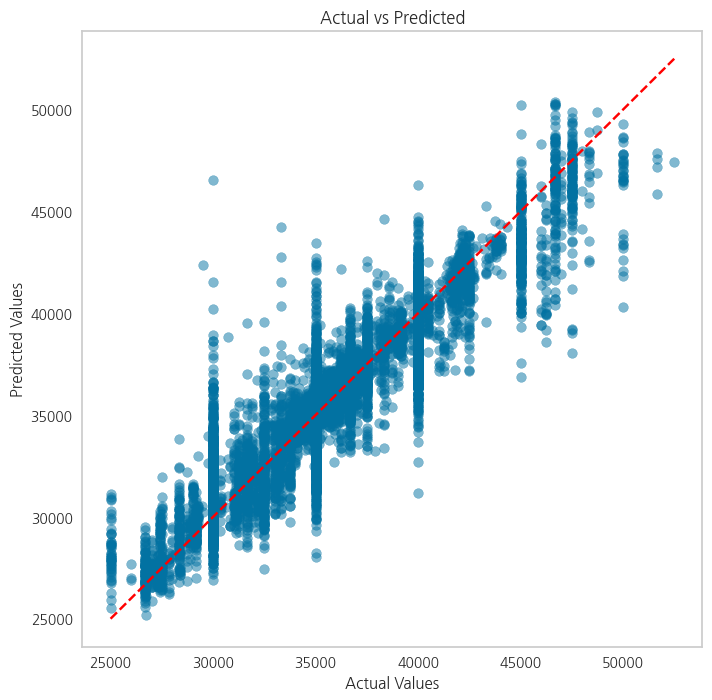

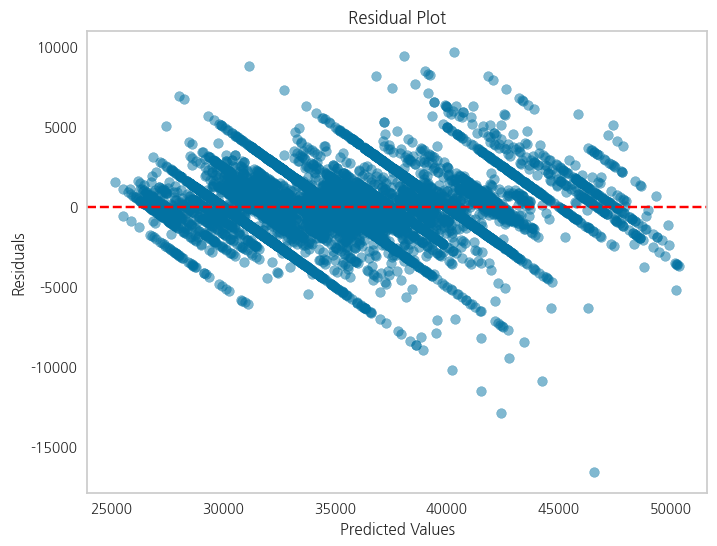

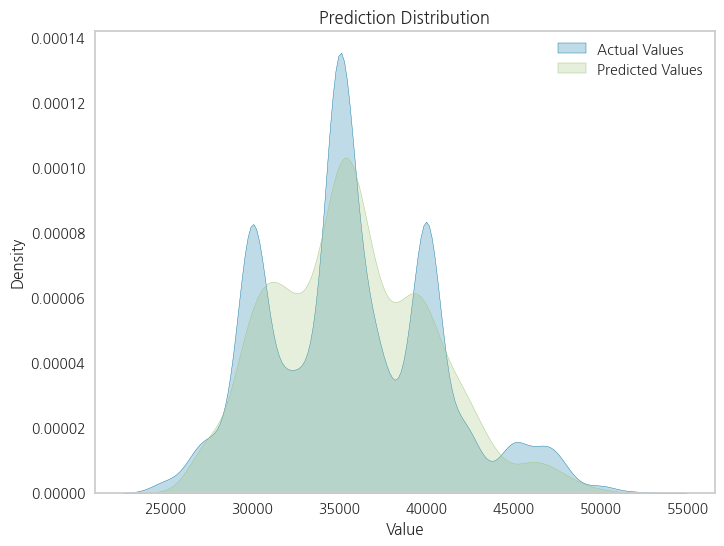

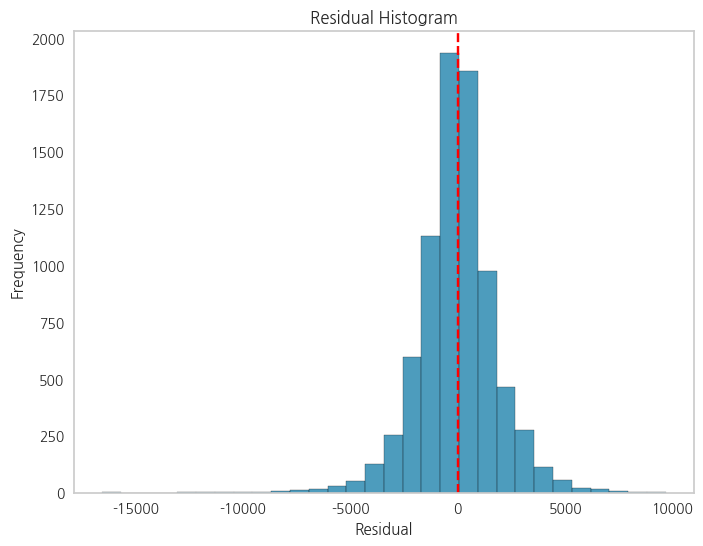

In [40]:
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# PyCaret의 predict_model 함수로 예측 수행
predictions = predict_model(tuned_lgbm_model)

# 실제 값과 예측 값 추출
y_true = predictions["avgPrice"]
y_pred = predictions["prediction_label"]

# R2 및 RMSE 계산
r2 = r2_score(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# 1. 실제 값 vs 예측 값 플롯
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", linestyle="--")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()

# 2. 잔차 플롯
residuals = y_true - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# 3. 예측 값 분포
plt.figure(figsize=(8, 6))
sns.kdeplot(y_true, label="Actual Values", shade=True)
sns.kdeplot(y_pred, label="Predicted Values", shade=True)
plt.title("Prediction Distribution")
plt.xlabel("Value")
plt.legend()
plt.grid()
plt.show()

# 4. 잔차 히스토그램
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.title("Residual Histogram")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color="red", linestyle="--")
plt.grid()
plt.show()


### 피처 선택 후 성능 확인
- 13_18, 19_24, 50_54, 55_59
- 결과 -> 주성분 3개 보단 좋지만 주성분 6개 보다는 안좋다

In [46]:
from pycaret.regression import setup, create_model, tune_model


df_merged = gen_merge_dataset(
    fill=False,
    item="광어",
    drop_cols=["avgPrice_lag_1", "avgPrice_lag_2", "avgPrice_lag_3", "avgPrice_lag_7"],
    age=['13_18', '19_24', '50_54', '55_59'])

# PyCaret 설정
setup(data=df_merged, target="avgPrice", session_id=1030)

# LightGBM 모델 생성
lgbm_model = create_model("lightgbm")
lgbm_model.get_params()

,Description,Value
0,Session id,1030
1,Target,avgPrice
2,Target type,Regression
3,Original data shape,"(26526, 9)"
4,Transformed data shape,"(26526, 36)"
5,Transformed train set shape,"(18568, 36)"
6,Transformed test set shape,"(7958, 36)"
7,Numeric features,4
8,Categorical features,4
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1846.6828,6359673.6603,2521.8393,0.7222,0.0710,0.0525
1,1775.3277,5962716.5281,2441.8674,0.7518,0.0691,0.0508
2,1810.4767,6218970.1955,2493.7863,0.7405,0.0699,0.0516
3,1880.5808,6576265.0007,2564.4229,0.7120,0.0728,0.0541
4,1909.4782,7043494.4242,2653.9583,0.7061,0.0750,0.0548
5,1804.5387,6146102.5884,2479.1334,0.7476,0.0700,0.0515
6,1835.4559,6122418.7399,2474.3522,0.7376,0.0704,0.0529
7,1854.5641,6242588.5822,2498.5173,0.7402,0.0715,0.0537
8,1836.8537,6300438.7473,2510.0675,0.7290,0.0722,0.0537


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 1030,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}